# Daily Step Analysis Report

In [130]:
# Copy from Emily's notebook
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
    <script> code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle);</script>
    <form action="javascript:code_toggle()"><input type="submit" value="Hide/show all code."></form>
''')

## Introduction

### Dataset

Most of the datasets are provided in DATA3406 unit in The University of Sydney. 8 participants are given full consent and volunteered to share their step data extracted from sellphone. One dataset is taken from one of my friends and they approve us to use it in our report. 

### Problem

We tackle on finding a pattern in their step count. Specifically, we look into whether there is some patterns exist in different weekdays. We look at 5 aspects in details which are shown following:
+ The percentage of days which less than 5 thousand, reached at 5 thousand and reached at 10 thousand
+ The trend of achiving 7.5 thousand steps and 10 thousand steps
+ The difference between weekday and weekend
+ The pattern within the day (morning, afternoon, night)
+ The monthly pattern

All the sub questions are based on our driving question


## Ethical Analysis

### Stakeholder

+ Data Owner
    + Data owner could beneficial from the report since they could know themselves better

### Potential issues

The data might not reflect on the real steps. The reason is people do not always take their sellphone while they walking. For example, someone may leave the phone at their home if they only want to walk around after dinner.


### Benefits

The result of the report would benefit the dataset owner. They have the right to know what we have done to their data. To thus, they could know better of themselves. For example, in our report, one of the visualization listing the percentage of days which steps range between 0-5000, 5000-10000, and >10000. The particpants would know which weekday is relatively "unhealthy" and they could have a better cognition of themselves.

### Consent

As we mentioned before, informed consent has been checked for each participant. Also, there is no personal data other than step counts. The detailed step counts would not be provided in this report so that their privacy could be fully protected.

## Analysis

### Import involved packages

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import chi2 
import scipy.stats as stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
from pandas.api.types import CategoricalDtype
import plotly.graph_objects as go
from pathlib import Path

All required packages are imported

### Read datasets

We will use participant 7 as an example. Now, let's read the dataset and modify the columns.

In [94]:
def sub(data):
#     convert start,finish columns to datetime formats
    data['Start'] = pd.to_datetime(data['Start'])
    data['Finish'] = pd.to_datetime(data['Finish'])
#     extract the weekday name, month names and date in YYYY-MM-DD format from start column
    data['Weekday'] = data['Start'].dt.day_name()
    data['Month'] = data['Start'].dt.month_name()
    data['Year'] = data['Start'].dt.year
    data['Date'] = data['Start'].dt.date
#     convert date to datetime format
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.rename(columns = {"Steps (count)":"Steps"})
#     week days are ordered so that it's matches the order that day of the week are.
    cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    cat_type = CategoricalDtype(categories=cats, ordered=True)
    data['Weekday'] = data['Weekday'].astype(cat_type)
def read_data(path):
    # read the path of the dataset file and make a copy to ensure data security.
    df = pd.read_csv(path)
    df_copy = df.copy()
    # Modify the Columns feature and rename Columns
    df_copy['Start'] = pd.to_datetime(df_copy["Start"])
    df_copy['Date'] = df_copy['Start'].dt.date
    df_copy['Date'] = pd.to_datetime(df_copy['Date'])
    df_copy['Weekday'] = df_copy['Date'].dt.day_name()
    df_copy['Date'] = pd.to_datetime(df_copy['Date'])
    # Using Emily's idea to reorder the weekday columns
    df_copy = df_copy.rename(columns = {"Steps (count)":"Steps"})
    df_copy = df_copy.drop(columns = ["Start","Finish"])
    cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    cat_type = CategoricalDtype(categories=cats, ordered=True)
    df_copy['Weekday'] = df_copy['Weekday'].astype(cat_type)
    return df_copy

df_P7 = pd.read_csv("../../../datasets/Participant-07.csv").copy()
df_P7 = df_P7.rename(columns={'Steps (count)':'Steps'})


sub(df_P7)

After this, we could start analyzing the dataset with the driving question and sub questions.

### Data Exploration

Firstly, we will look at some statistics of the dataset

In [95]:
def day(df):
    day = df.groupby(['Date'], as_index=False).agg({'Steps': 'sum','Weekday': 'first','Month': 'first'})
    #day = df.groupby(['Date'], as_index=False).agg({'Steps': 'sum','Weekday': 'first'})
    return day
day = day(df_P7)
day.describe()

,Steps
count,256.000000
mean,7748.444263
std,2583.766599
min,1346.000000
25%,6134.250000
50%,7786.500000
75%,9805.258961
max,15092.000000


We can summary that we have 256 days in the dataset. The mean of steps in those 256 days was about 7748. The most inactive day reached 1346 steps and the most active day reached 15092 steps.

Then, we have a simple bar plot to visualize the steps the participant took at the single weekday.

In [96]:
fig = go.Figure()
fig.add_trace(
    go.Bar(x=day["Weekday"], y=day["Steps"],name='Participant 7'))
fig.update_xaxes(categoryorder='array', categoryarray= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

Looking at the plot, we can observe that friday and sunday is the least active weekday, where as monday is the most active day compare to the others. We are not taking the mean to make the graph, the reason is that the data is continuious which means each weekday split equally. Taking the mean would make it harder to see the pattern. Also, another thing we can observe is at the first 10 weeks for Sunday, it seems that the participant is very inactive. Then, at the last few months, he is more active.

# Sub question

## Weekday vs Weekend

We are interested in how is weekday and weekend behave differently for this participant.

In [97]:
# 
def isWeekend(df):
    df['Week'] =  df['Date'].dt.isocalendar().week
    df["Is Weekend"] = df['Date'].dt.dayofweek > 4
    df.drop(df[df['Week'] == 52].index, inplace = True)
    df = df.groupby(['Is Weekend','Week']).agg({'Steps': 'mean'}).reset_index()
    fig = go.Figure()
    wkdf = df.loc[df["Is Weekend"]==True]
    wddf = df.loc[df["Is Weekend"]!=True]
    fig.add_trace(
        go.Scatter(x=wkdf["Week"], y=wkdf["Steps"],name='Participant 7 Weekend'))
    fig.add_trace(
        go.Scatter(x=wddf["Week"], y=wddf["Steps"],name='Participant 7 Weekday'))
    fig.show()

isWeekend(day)

In this graph, x-axis represents week. The points are calculated by taking the mean of all the weekend/weekday in that week. We could observe that this participant is more active on weekday rather than weekend. In week 3 and 26, we can see a large difference between the mean.

## Monthly trend

Next, we are going to see whether there is a difference between different month based on each week day

/var/folders/94/d6zglr4j7fs8fyf3mq_1t2_w0000gn/T/ipykernel_2825/1213701438.py:26: UserWarning:

FixedFormatter should only be used together with FixedLocator



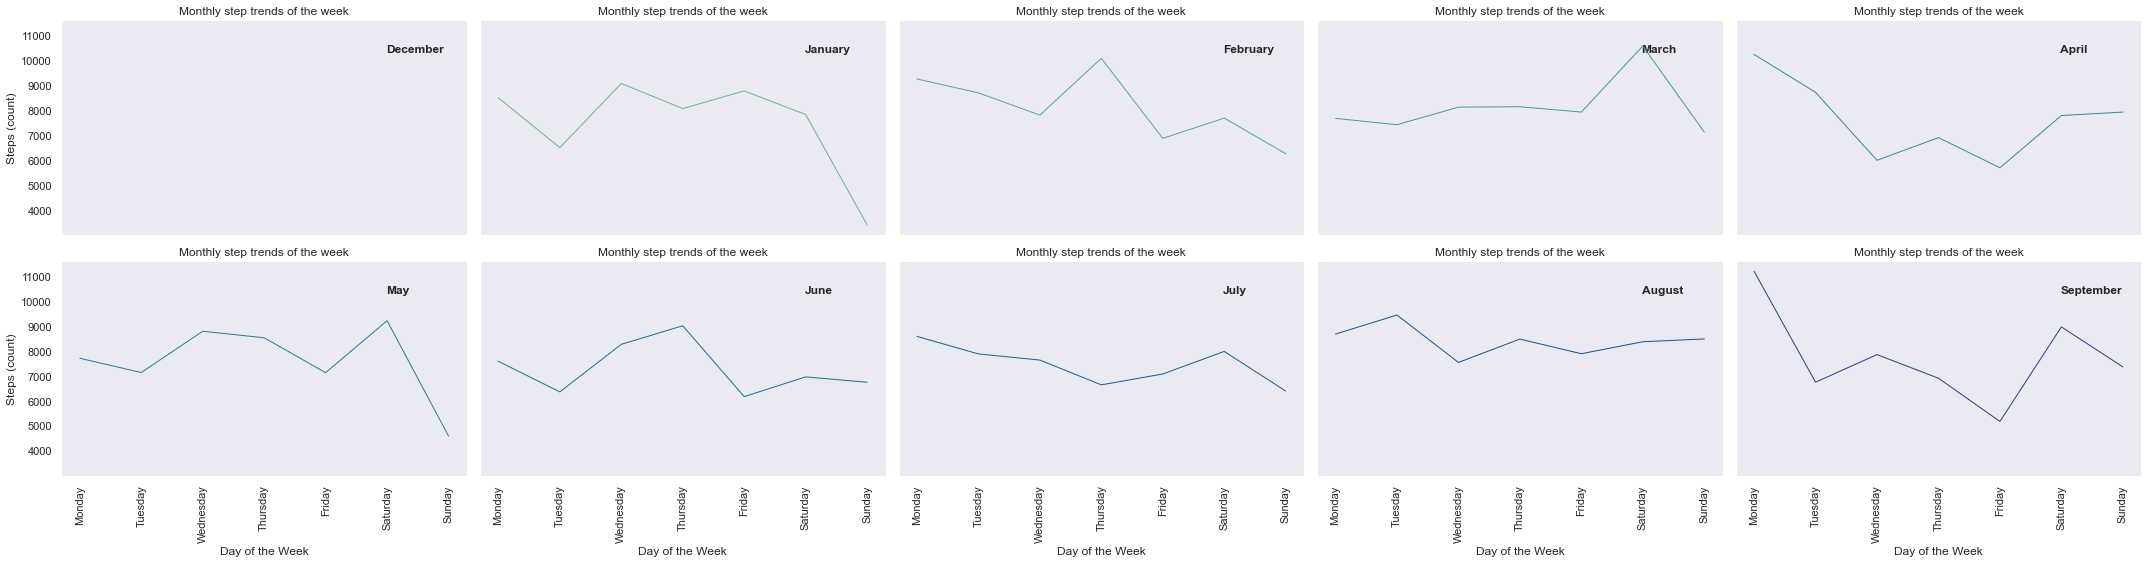

In [100]:
# Copy from Emily's personal notebook
def graphmonth(df): 
        # order the months
    cat2 = ['December','January','February','March','April','May','June','July','August','September']
    cat2_type = CategoricalDtype(categories=cat2, ordered=True)
    df['Month'] = df['Month'].astype(cat2_type)
    cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    cat_type = CategoricalDtype(categories=cats, ordered=True)
    df['Weekday'] = df['Weekday'].astype(cat_type)    
    # group by month and weekday and get mean step count for all 3 participants
    week_month_count = df.groupby(['Month','Weekday']).agg({'Steps': 'mean','Date':'first'}).reset_index()

    sns.set_theme(style="dark")

    # Plot each months's step count for day of the week.
    g = sns.relplot(
        data=week_month_count,
        x="Weekday", y="Steps", col="Month", hue="Month",
        kind="line", palette="crest", linewidth=1, zorder=5,
        col_wrap=5, height=4, aspect=1.5, legend=False
    )

    # Iterate over each subplot to customize further
    for Month, ax in g.axes_dict.items():
        # Rotate the xticks by 90 degrees  
        ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
        # Add the title for the months as an annotation within the plot
        ax.text(.8, .85, Month, transform=ax.transAxes, fontweight="bold")


    # Tweak the supporting aspects of the plot
    g.set_titles("Monthly step trends of the week")
    g.set_axis_labels("Day of the Week", "Steps (count)")
    g.tight_layout()
graphmonth(day)

There is empty for December because there is no data for that month. For this participant, we can observe that Monday and Thursday are always at the top, whereas Sunday usually have less steps. July and August is relatively plain, which implies the participant have similar steps for each week day. Other than that, the patterns are various.

Then, we have a heatmap for a better visualization

In [101]:
# Taken from Emily
# create figure
fig = go.Figure()

hm = day.groupby(['Month','Weekday']).agg({'Steps': 'mean'}).reset_index()
hm = hm.pivot("Month", "Weekday", "Steps")
# Add surface trace
fig.add_trace(go.Heatmap(x=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'],y=['September','August','July','June','May','April','March','February','January','December'],z=hm, colorscale="YlGn"))



We could have a similar conclusion. We can see the color for Sunday is relatively light which implies less steps. The next least would be Friday. Especially in August and July, this could lead to the weather because August is cold. 

## Different time period trend

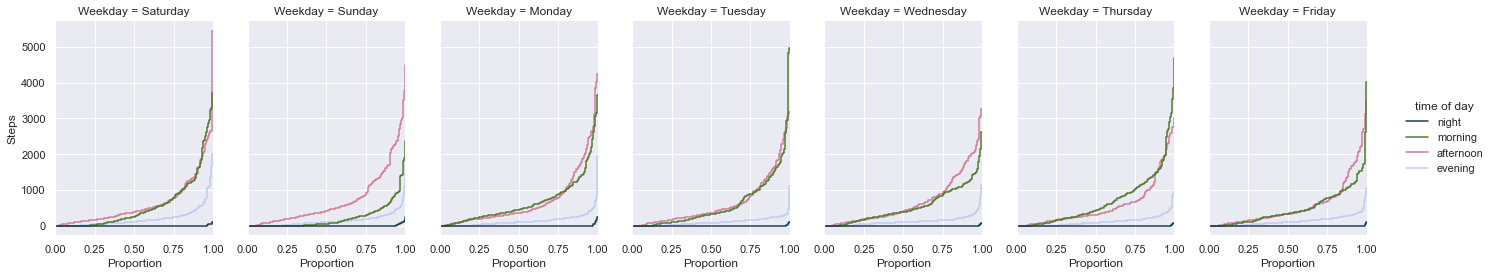

In [105]:
df_P7['Hour'] = df_P7['Start'].dt.hour
def graphhour(df):
    df["time of day"] = pd.qcut(df["Hour"], 4, labels = ["night", "morning", "afternoon", "evening"])
    
    sns.set(style="darkgrid") 
    plot = sns.displot(
        data=df, y="Steps", hue="time of day", col='Weekday',
        kind="ecdf", height=4, aspect=.7, palette="cubehelix"
    )
graphhour(df_P7)

Clearly, we can see that night period is the least active one for this participant. Probably this period is covered with his sleeping period. The next inactive period is evening which is 18:00-24:00 p.m. We can observe that Saturday is the active day in evening compare to the other week day. We can then guess the participant usually go out for fun at Saturday night because he/she could chill at Sunday. This could be proved as the Sunday morning is the most inactive day within all the week day. Additionally, Tuesday is probably the most active day at morning time (6am-18pm).

We then have a heatmap to hourly period for the participant.

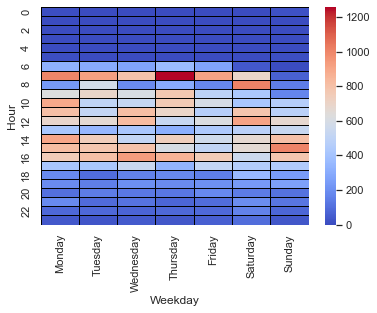

In [111]:
def graphhour3(df):
    # obtain the mean step counts for each hour of each day of the week
    hour_dow_count = df.groupby(['Hour','Weekday']).agg({'Steps': 'mean'}).reset_index()
    # change the format such that each cell contains a step count value
    hour_dow_count = hour_dow_count.pivot("Hour", "Weekday", "Steps")
    # change the order of the days of the week
    hour_dow_count = hour_dow_count.reindex(
        columns = [
        'Monday',
        'Tuesday',
        'Wednesday',
        'Thursday',
        'Friday',
        'Saturday',
        'Sunday'])
    # plot the heatmap
    hmap = sns.heatmap(hour_dow_count, cmap="coolwarm", linewidths=.5, linecolor = 'black')

graphhour3(df_P7)

The pattern is the participant always walk a lot at 7 a.m at become very inactive at 8 a.m. We could reasonbly guess he/she go to library or have classes at 8 a.m. Also, the participant is inactive at 13 p.m. The reason could be the participant usually take a nap at this time.

## Proportion of inactive, moderate active and active days

We define inactive day to be days less than 5000, moderate active day to be between 5000 - 10000 and active day would larger than 10000.

,Weekday,<5k,5k-10k,>10k
0,Monday,3,19,15
1,Tuesday,8,18,11
2,Wednesday,4,23,9
3,Thursday,6,19,11
4,Friday,5,27,4
5,Saturday,2,25,10
6,Sunday,10,25,2


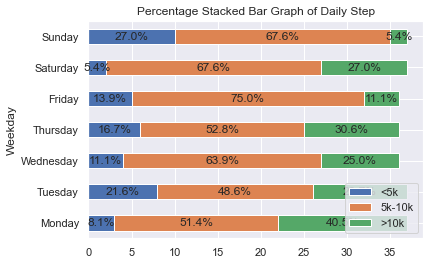

In [119]:
def sub_q(df):
    df = df.groupby('Date').agg({'Steps':'sum','Weekday':'first'}).reset_index()
    # df = df.assign(Health_index = lambda x: (x['Steps']))
    df.loc[df['Steps'] < 10000,'Step_index'] = '5k-10k'
    df.loc[df['Steps'] < 5000,'Step_index'] = '<5k'
    df.loc[df['Steps'] > 10000,'Step_index'] = '>10k'
    df = df[['Weekday','Step_index']].copy()
    cats = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    cat_type = CategoricalDtype(categories=cats, ordered=False)
    df['Weekday'] = df['Weekday'].astype(cat_type)
    # grouped = df.groupby(by = ['Weekday','Step_index']).count()
    df = pd.get_dummies(df['Step_index']).groupby(df['Weekday']).sum().reset_index()
    df = df.loc[:,['Weekday','<5k','5k-10k','>10k']]
    df.plot(
        x = 'Weekday',
        kind = 'barh',
        stacked = True,
        title = 'Percentage Stacked Bar Graph of Daily Step',
        mark_right = True)
    df_total = df['<5k'] + df['5k-10k'] + df['>10k']
    df_rel = df[df.columns[1:]].div(df_total, 0)*100

    for n in df_rel:
        for i, (cs, ab, pc) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], 
                                             df[n], df_rel[n])):
            plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', 
                     va = 'center', ha = 'center')
    return df

sub_q(df_P7)

Firstly,the percentage of inactive day for Saturday and Sunday differs a lot. We can guess he/she is not energetic after going out at late night at Saturday. Tuesday is another inactive day, the participant may do not have any classes at that day. In addition, we can see Friday has a lot of moderate active day but very few active day. This is explainable as Friday is the last day for either study or work. After class/work, participant may get tried of doing anything else.

## Frenquency of reaching the recommended 7500 and 10000 step goal

Furthermore, we would like to investigate the frenquency for the participant to achieve the recommended daily step which is 7500 and 10000.

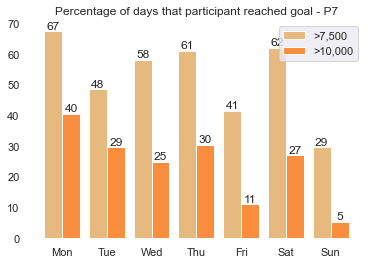

In [127]:
pat_p7 = df_P7.groupby('Date').agg({'Steps':'sum','Weekday':'first'}).reset_index()
def plot_weekday_patterns(daily_sums, suffix):
    cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    cat_type = CategoricalDtype(categories=cats, ordered=True)
    daily_sums['Weekday'] = daily_sums['Weekday'].astype(cat_type)  
    num_weekday_days = daily_sums.groupby('Weekday').size()
  
    p_days_7500 = daily_sums[daily_sums['Steps'] > 7500].groupby('Weekday').size() / num_weekday_days * 100
    p_days_10000 = daily_sums[daily_sums['Steps'] > 10000].groupby('Weekday').size() / num_weekday_days * 100

    x = np.arange(7)
    width = 0.4

    fig, ax = plt.subplots()

    bar_7500 = ax.bar(x - width / 2, p_days_7500, width=width, color='#E6BA7E', label='>7,500')
    ax.bar_label(bar_7500, fmt='%d')
    bar_10000 = ax.bar(x + width / 2, p_days_10000, width=width, color='#FA8D3E', label='>10,000')
    ax.bar_label(bar_10000, fmt='%d')
    weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    ax.set(frame_on=False)
    plt.title(f'Percentage of days that participant reached goal - {suffix}')
    plt.xticks(x, labels=weekdays)
    plt.legend()
    plt.show()

plot_weekday_patterns(pat_p7, 'P7')

If we use 7500 steps per day as a standard, the participant have half of the days which pass the criteria. However, there is a sharp gap between pass 7500 and pass 10000 steps.  

## Conclusion

To conclude with, the participant is less active at Sunday and most active at Monday. He/She takes a lot of steps at morning and afternoon. He/She usually have steps range at 5000-10000 but seldomly reach at 10000 steps. July and August was very inactive compare to the other months. All in all, the participant has a good habit of walking, every week day is moderate active except for Sunday. 